In [1]:
from pycocotools.coco import COCO
annotation_file = "label_data/train.json"
image_dir = "label_data/images"

coco_train = COCO(annotation_file)

# Check the categories in the dataset
categories = coco_train.loadCats(coco_train.getCatIds())
category_names = [category['name'] for category in categories]
print("There are {} categories in the dataset. The categories are: {}".format(len(categories), category_names))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
There are 10 categories in the dataset. The categories are: ['box', 'child', 'green_light', 'left_arrow', 'no_light', 'person', 'red_light', 'right_arrow', 'tree', 'unknown_arrow']


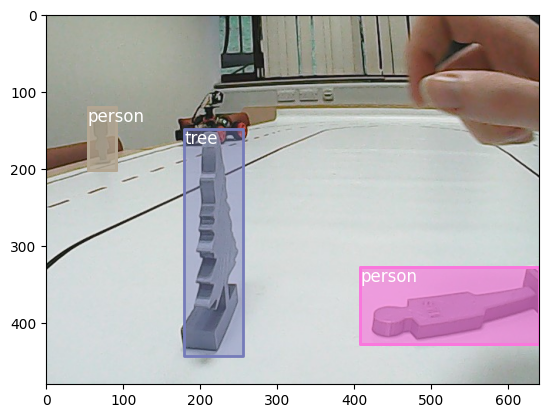

In [2]:
# Load a random image, display it + annotations
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np

img = coco_train.loadImgs([1])[0]
img = plt.imread(image_dir + "/" + img['file_name'])

plt.imshow(img)

# Plot bounding boxes
ann_ids = coco_train.getAnnIds(imgIds=[1])
anns = coco_train.loadAnns(ann_ids)

ax = plt.gca()
ax.set_autoscale_on(False)
polygons = []
color = []

for ann in anns:
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    
    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
    np_poly = np.array(poly).reshape((4,2))
    polygons.append(Polygon(np_poly))
    color.append(c)
    
    p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)
    
    # Add the category label
    category_id = ann['category_id']
    category = coco_train.cats[category_id]['name']
    plt.text(bbox_x, bbox_y, category, fontsize=12, color='white', verticalalignment='top')
    
plt.show()


In [3]:
from pprint import pprint

# Load annotations for all images
img_ids = coco_train.getImgIds()
all_annotations = []
for img_id in img_ids:
    img = coco_train.loadImgs([img_id])[0]
    ann_ids = coco_train.getAnnIds(imgIds=[img_id])
    anns = coco_train.loadAnns(ann_ids)
    all_annotations.append(anns)
    
print("Number of images: {}".format(len(all_annotations)))

# Train/test split
import random
random.seed(0)
random.shuffle(all_annotations)
split = int(0.8 * len(all_annotations))
train_annotations = all_annotations[:split]
test_annotations = all_annotations[split:]

print("Number of training images: {}".format(len(train_annotations)))
print("Number of test images: {}".format(len(test_annotations)))


Number of images: 304
Number of training images: 243
Number of test images: 61


In [2]:
import keras
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
from pycocotools import coco
from pprint import pprint

BATCH_SIZE = 4
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"
AUTOTUNE = tf.data.AUTOTUNE

train_annotations = "label_kaggle_training/result.json"
train_images = "label_kaggle_training/images"
coco_train = coco.COCO(train_annotations)

val_annotations = "label_kaggle_test/result.json"
val_images = "label_kaggle_test/images"
coco_val = coco.COCO(val_annotations)

categories = coco_train.loadCats(coco_train.getCatIds())
class_map = {category['id']: category['name'] for category in categories}

pprint(class_map)

2024-04-24 12:25:09.582259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 12:25:10.349741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dino/miniconda3/envs/picar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{0: 'box',
 1: 'green_light',
 2: 'left_arrow',
 3: 'no_light',
 4: 'person',
 5: 'red_light',
 6: 'right_arrow',
 7: 'tree',
 8: 'unknown_arrow'}


In [3]:
def getAnnotations(coco_instance, image_id):
    ann_ids = coco_instance.getAnnIds(imgIds=[image_id])
    anns = coco_instance.loadAnns(ann_ids)
    
    bboxes = []
    category_ids = []
    
    for ann in anns:
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        
        bboxes.append(bbox)
        category_ids.append(category_id)
    
    return {'boxes': bboxes, 'classes': category_ids}
        
def loadImage(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, IMAGE_SIZE) # Screws up bounding boxes, we'll add it as a preprocessing layer
    image = tf.cast(image, tf.float32)
    return image

def loadDatapaths(coco_instance, image_dir):
    img_ids = coco_instance.getImgIds()
    img_paths = []
    boxes = []
    classes = []
    
    for img_id in img_ids:
        img = coco_instance.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img["file_name"])
        
        annotations = getAnnotations(coco_instance, img_id)
        
        if len(annotations["boxes"]) > 0 and len(annotations["classes"]) > 0:
            img_paths.append(img_path)
            boxes.append(annotations["boxes"])
            classes.append(annotations["classes"])
        
    return img_paths, boxes, classes

def loadDatapoint(img_path, boxes, classes):
    image = loadImage(img_path)
    bbox = {"boxes": boxes, "classes": classes}
    return {"images": image, "bounding_boxes": bbox}

def loadDataset(coco_instance, image_dir):
    img_paths, boxes, classes = loadDatapaths(coco_instance, image_dir)
    img_paths = tf.ragged.constant(img_paths)
    boxes = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(classes)
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, boxes, classes))
    dataset = dataset.map(loadDatapoint, num_parallel_calls=AUTOTUNE)
    dataset = dataset.ragged_batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.shuffle(8 * BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [9]:
train_dataset = loadDataset(coco_train, train_images)
val_dataset = loadDataset(coco_val, val_images)

In [10]:
def visualiseDataset(inputs, value_range=(0, 255), rows=2, cols=2, bounding_box_format=BBOX_FORMAT):
    inputs = next(iter(inputs.take(1)))
    images = inputs["images"]
    bounding_boxes = inputs["bounding_boxes"]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_map
    )

Number of training batches: 1218


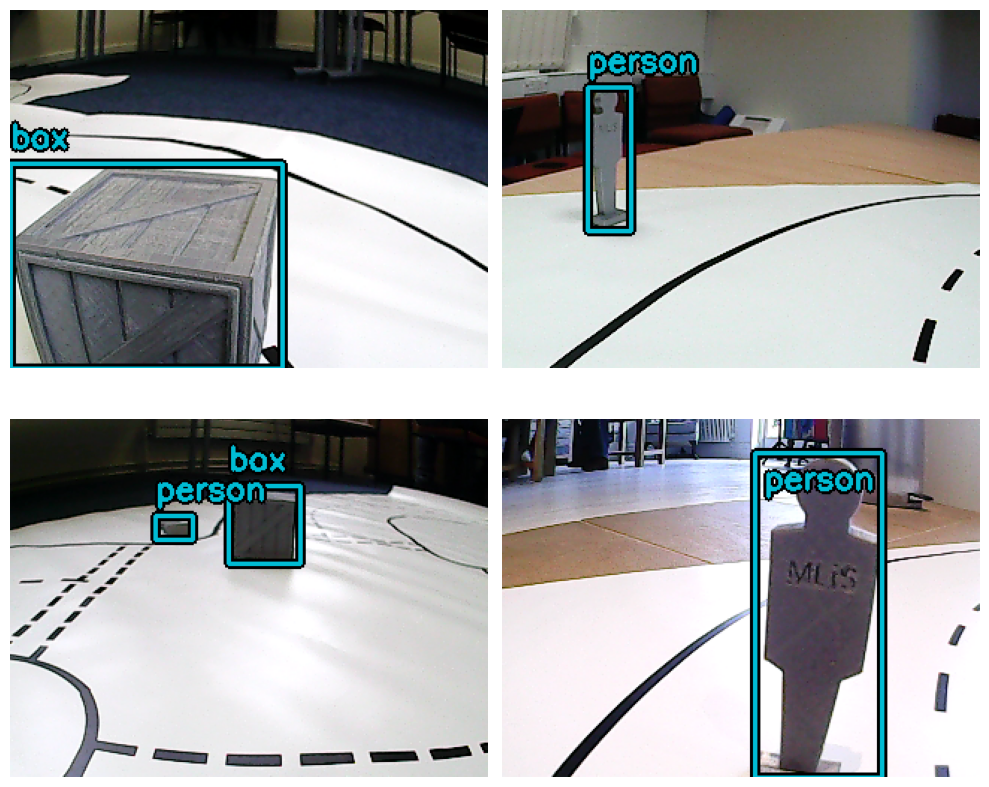

In [11]:
print("Number of training batches: {}".format(len(train_dataset)))
visualiseDataset(train_dataset)

2024-04-24 12:26:30.572896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node rand_augment_2_1_map_while_cond_1_false_3973}}{{node rand_augment_2_1/map/while/cond_1/random_choice_2_1/stateful_uniform/RngReadAndSkip}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-24 12:26:30.572996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4761739974150586760
2024-04-24 12:26:30.573009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7824637057774850920
2024-04-24 12:26:30.573016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14122917193230730874
2024-04-24 12:26:30.573024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node rand_

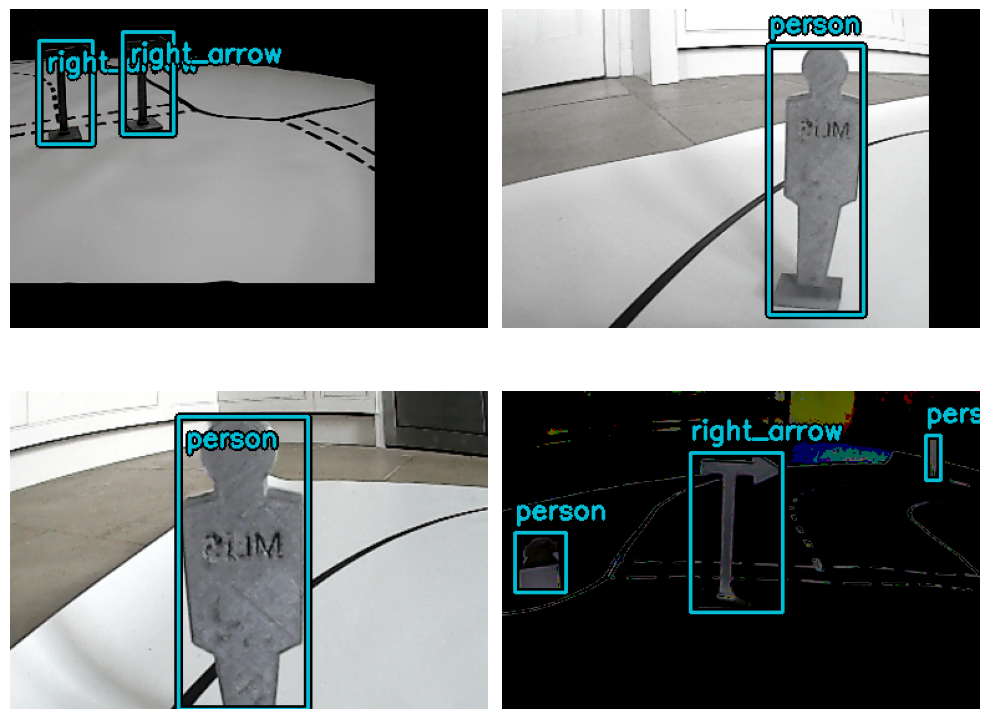

In [12]:
# TODO: Try MixUp
bbox_augmenters = [
    keras_cv.layers.JitteredResize(
        target_size=IMAGE_SIZE,
        scale_factor=(0.75, 1.3),
        bounding_box_format=BBOX_FORMAT
    )
]

image_augmenters = [
    keras_cv.layers.RandAugment(
        value_range=(0, 255),
        geometric=False
    )
]

def createAugmenterFunction(augmenters):
    def augmenterFunction(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenterFunction

bbox_augmenter = createAugmenterFunction(bbox_augmenters)
image_augmenter = createAugmenterFunction(image_augmenters)

train_dataset = train_dataset.map(bbox_augmenter, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(lambda x: {"images": image_augmenter(x["images"]), "bounding_boxes": x["bounding_boxes"]}, num_parallel_calls=AUTOTUNE)

visualiseDataset(train_dataset)


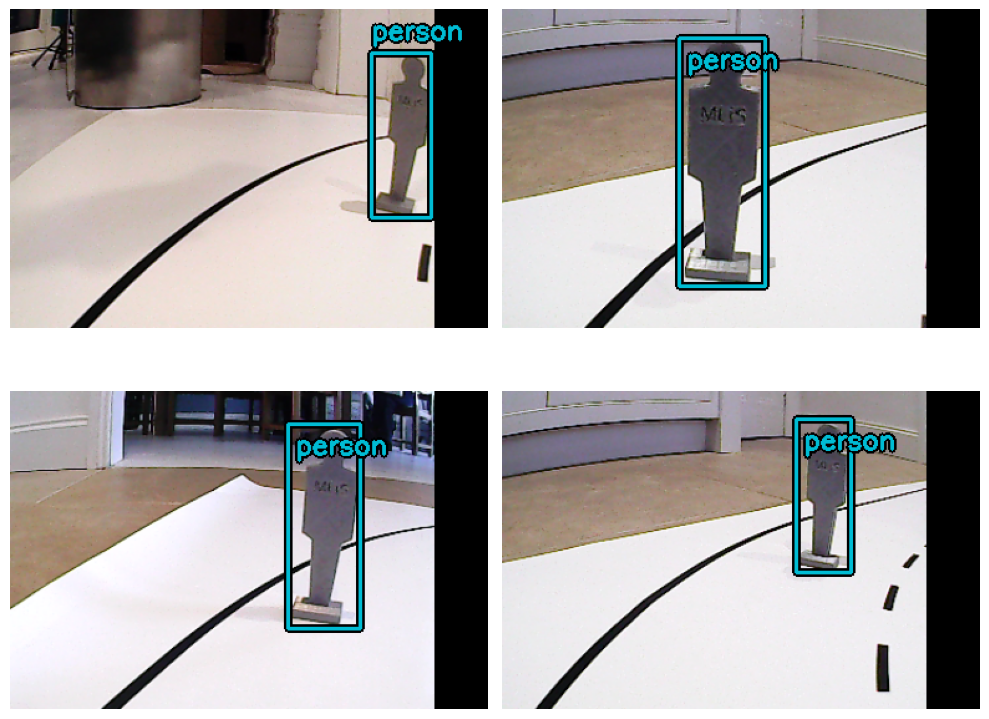

In [13]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True
)

val_dataset = val_dataset.map(validation_resizing, num_parallel_calls=AUTOTUNE)

visualiseDataset(val_dataset)

In [ ]:
# To be TPU compatible, bounding box tensors must be Dense, not Ragged
def dictToTuple(inputs):
    return (inputs["images"], keras_cv.bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32))